# Predicting credit default

In this notebook we show how one can predict whether a customer will default on the repayment of their credit card loans using a variety of models. We will use the prepared dataset from the EDA notebook for this.

## Dataset preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from plotnine import *
import os
import datetime
import pickle
import json

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
# constants
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [4]:
# first we read in the feather file with the input features
credit_card_df = pd.read_feather(os.path.join('..', 'dataset', 'modelling_dataset.feather'))

In [5]:
credit_card_df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,max_delay,freq_delay
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,2,2
1,2,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,2,5
2,3,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,0,6
3,4,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,0,6
4,5,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,0,4


# Creating the train, test, and validation splits

- **We split the dataset into train, validation, and test**

- We will set test aside, which will be used to evaluate the final performance of the model. Then we will use train and validation to fit the actual model.

- Note that since our dataset is imbalanced, we must make sure that the distribution of the target across train, validation, and test is balanced, otherwise we run the risk of e.g. not have sufficient default cases in the test set, for instance.

- The reason why we split the data into train, validation, and test is that we want to train the model and then evaluate the model accuracy on data **that the model has never seen**. This is the only way to accurately evaluate the predictive performance of a model.

- There are no hard-and-fast rules on how you have to split the data into train, validation, and test, only rules of thumb. The general idea is that you should have enough training examples to minimize the variance (uncertainty) on the model parameters, and enough test examples to minimize the variance (uncertainty) on the model performance metrics

- If there is enough data, the following algorithm to split into train/validation/test is the standard one:
    - split the dataset into fitting data (80%) and test set (20%)
    - split the fitting data further into train set (80% of the fitting data) and validation set (20% of the fitting data)
- If there is not enough data, then crossvalidation is the only option in order to find the best model parameters

**Software engineering intermezzo**

In this course, we focus on model building rather than programming patterns, but in a **real** machine learning project the software engineering/IT part of the project is typically as important as the modelling part (and sometimes more...). One important programming pattern that every data scientist should know is *object oriented programming*. In the code we have seen until now, we mostly worked with python functions. However, sometimes one would like to have a way to combine multiple functions and some data into a single unit of behaviour.

For instance, consider the task of modelling a bank customer. This *entity* could be modelled as a dictionary where we store, e.g., the customer name, his date of birth, and the balance of his bank account.

In [6]:
customer = {
    "balance": 1000,
    "name": "John",
    "birthdate": "1980-01-01"
}

Now, there are many things we might want to do with customers. For instance, we might want to change their balance when they make a transaction. We could do that with a function set_balance, for instance.

In [7]:
def set_balance(customer, new_balance):
    customer["balance"] = new_balance

set_balance(customer, 500)
customer

{'balance': 500, 'name': 'John', 'birthdate': '1980-01-01'}

That's great. However, there are many other operations we might want to do on a customer. For instance, we might want to:

1. Calculate the current age of the customer
2. Change the customer name

And many others. If we had a function for each operation we want to do on the customer, this might start being rather messy, in particular if the functions change the **state** of the customer object, e.g., by resetting the balance of the customer. Consider that in a realistic scenario we might have millions of customers and you can see the problem.

In **object oriented programming**, we deal with this problem by defining a customer **class** which we can use to create individual customers.

This class is essentially a template/blueprint to create customer objects. It specifies which data attributes the customer objects have (like birthdate, name, etc.). It also specifies which **methods** the customer objects have. Methods are like functions, but they are bound to a specific class object and they act/modify that object. When we have a class, we can create objects from it simply by calling it, and passing to it the values of the attributes (e.g. balance) that we want the new object to have. These values are passed to a special __init__ method, which then sets the passed arguments on the object.

The following is an example of a customer class with an init method and a couple of the methods discussed above:

In [8]:
class Customer():
    def __init__(self, balance, name, birthdate) -> None:
        self.name = name
        self.balance = balance
        self.birthdate = birthdate
        
    def set_balance(self, new_balance):
        self.balance = new_balance
        
    def change_name(self, new_name):
        self.name = new_name
        
# with this class, we can now create a customer object
customer1 = Customer(balance=1000, name="John", birthdate="1980-01-01")
# but we can use the class to create multiple customers, with different attribute values
customer2 = Customer(balance=400, name="Andy", birthdate="1991-05-16")
customer3 = Customer(balance=100, name="Pamela", birthdate="1960-03-20")

# we can then call the methods on the specific customers to change/get values for that customer
print("Customer 1 initial balance: {}".format(customer1.balance))
customer1.set_balance(1500)
print("Customer 1 new balance: {}".format(customer1.balance))

Customer 1 initial balance: 1000
Customer 1 new balance: 1500


Note how the class is called with the values of the attributes that you want to use when you create the customer object. These are passed to the __init__ method, which then creates the customer object. Note moreover how every method in the class has a `self` argument. This argument refers to the specific customer object instance that we have when we call the method on a customer instance, and can be used to e.g. change the attribute values of that customer instance.

The entire sklearn library that we use for machine learning in this course is build on object oriented programming, so it's important to have at least an idea of what that is. Now that we have seen an abstract example, we can see a more concrete example by using object oriented programming to split our data into training, validation, and test set.

In [6]:
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed
    
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            default_count = (getattr(self, i).groupby('default').size().reset_index())
            split_stats['N_defaults'] = (default_count.loc[lambda x: x.default ==1, 0].iloc[0])
            split_stats['percentage_total_defaults'] = split_stats['N_defaults']/self.total_n_defaults * 100
            split_stats['N_not_defaults'] = default_count.loc[lambda x: x.default == 0, 0].iloc[0]
            split_stats['percentage_total_not_defaults'] = split_stats['N_not_defaults']/self.total_n_not_defaults * 100
            statistics[i] = split_stats
        self.split_statistics = statistics

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_n_defaults = df.loc[lambda x: x.default == 1].shape[0]
        self.total_n_not_defaults = df.loc[lambda x: x.default == 0].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [7]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [8]:
fitting_splits.split_train_test(credit_card_df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [9]:
fitting_splits.test_set.shape

(6000, 27)

In [10]:
fitting_splits.split_statistics

{'train_set': {'N_defaults': 4232,
  'percentage_total_defaults': 63.773357444243516,
  'N_not_defaults': 14968,
  'percentage_total_not_defaults': 64.06437253894882},
 'test_set': {'N_defaults': 1307,
  'percentage_total_defaults': 19.695599758890896,
  'N_not_defaults': 4693,
  'percentage_total_not_defaults': 20.086457798322204},
 'validation_set': {'N_defaults': 1097,
  'percentage_total_defaults': 16.53104279686558,
  'N_not_defaults': 3703,
  'percentage_total_not_defaults': 15.849169662728984}}

Consider the split statistics above, and note how we have ~64% of the default cases in the training set, ~20% of the default cases in the test set, and ~16% of the default cases in the validation set. We conclude that the split is representative of the class balances, and we can proceed with modelling.

# Dummification and scaling

Before fitting a model to our data, we need to deal with two data transformations that are **essential** to be able to obtain a performant model. These are **dummification** or **one-hot-encoding** and **scaling**.

### Dummification
- **Dummification** is used to transform categorical variables into numerical variables, since most machine learning models can only deal with numerical variables. You probably already encountered this in your statistics course since linear regression requires dummification.
- In dummification, we transform a categorical variable with N values into C_0, ..., C_N columns that take only 0 or 1 values. A row then has exactly one of these columns with 1, and the others with 0, namely, the column corresponding to the original value of the categorical variable for that row.
- Note that there are alternative ways to deal with categorical variables. One is to use ordinal encoding, which simply encodes the categorical variable as integers. In the above dataset, the categorical variables of education, gender, marriage, etc. are ordinally encoded
- Ordinal encoding, however, introduces an order between the categories which doesn't necessarily make sense and can cause problems for ML algorithms. For instance, if we have two categories "male" and "female", and we encode them as 0 and 1, then we are also encoding that "male" < "female" since 0 < 1. Which does not make sense and can lead to issues with the models, for instance predictions in-between classes
- In our dataset, one might argue that while there is a natural order for education, no such order exists for sex and marriage. Therefore, we are going to one-hot encode the sex and marriage variables

We will use the sklearn one hot encoder to encode the sex and marriage variables. The education variable we will leave as an ordinal (integer) variable. See
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html for documentation.

### Scaling
- **feature scaling** refers to the application of a transformation to the numerical variables in the dataset which normalizes the range of the numerical variables, ensuring that these ranges are the same
- this is performed because often numerical variables can have wildly different ranges; for instance, the "age" variable in the above dataset has a very different range from the "limit_bal" variable.
- this can cause problems to machine learning models, in particular those, like SVM, that rely on measuring distances in e.g. Euclidean spaces. Without scaling, features whose range is in the high numers (e.g. limit_bal) will come to dominate the distance measures used in the algorithms, and features with ranges in the low numbers (e.g. age) will have little to no impact on the model
- there are many ways to standardize variables (https://en.wikipedia.org/wiki/Feature_scaling). The most common are:
    - min/max scaling
    - mean normalization
    - standardization (z-score calculation)

sklearn provides various classes to perform feature scaling. We are going to use the StandardScaler, which performs z-score standardization. See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for documentation.

In [11]:
# 1. fit a one hot encoder transformer to the TRAIN SET. The object we obtain will be reused later, to transform our data
# note: it is important that these transformers are fitted only on the train data.
one_hot_encoder = OneHotEncoder() # one hot encoder is a class instance
_ = one_hot_encoder.fit(fitting_splits.train_set[['sex', 'marriage']]) # we can fit the encoder instance on the columns that need to be transformed.

In [12]:
# let's check what the encoder did
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names_out() # with this method we can retrieve the names of the new dummy columns that have been computed
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['sex', 'marriage']]).toarray() # at this point, we can use the fitted encoder to transform any array with a sex and marriage column; not just the training set, but also the validation or test set. The encoder will take that array of shape (M,2) and transform it to an array of shape (M, N), where N is the total number of distinct possible values for the encoded features. The values of the new array will be either 0 or 1, encoding whether that value of the feature applies to the row.
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['1', '2'], dtype=object), array(['0', '1', '2', '3'], dtype=object)]

array(['sex_1', 'sex_2', 'marriage_0', 'marriage_1', 'marriage_2',
       'marriage_3'], dtype=object)

,sex_1,sex_2,marriage_0,marriage_1,marriage_2,marriage_3
0,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...
19195,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
19196,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
19197,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
19198,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [13]:
# after we have generated the dummy columns, we want to drop the original columns from the training data, and replace them with the dummy columns
train_set = fitting_splits.train_set.drop(['sex', 'marriage'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,limit_bal,education,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,...,pay_amt6,default,max_delay,freq_delay,sex_1,sex_2,marriage_0,marriage_1,marriage_2,marriage_3
0,13126,400000,1,34,-2,-2,-2,-2,-2,-2,...,0,0,-2,0,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000
1,14636,80000,2,34,0,0,0,0,0,0,...,2000,0,0,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
2,4382,20000,2,41,-1,-1,-1,-1,-1,-1,...,0,0,-1,0,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
3,7660,70000,1,36,2,0,0,0,0,0,...,0,0,2,6,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,10638,50000,2,24,0,0,0,0,0,0,...,1000,0,0,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,5299,200000,2,29,0,0,0,0,0,0,...,44701,0,0,6,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
19196,6120,50000,2,24,2,0,0,2,2,2,...,2200,1,2,6,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
19197,63,50000,1,29,2,2,2,2,2,2,...,0,1,2,6,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000
19198,3498,240000,2,37,-1,-1,-1,0,0,0,...,21257,0,0,3,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000


In [14]:
# now we fit the StandardScaler, in order to standardize all the features
standard_scaler = StandardScaler()
standard_scaler = standard_scaler.fit(train_set)

# the above standard scaler, when apply to a dataset with the same columns as the train set, will scale all the numerical features and return a numpy array
standard_scaler.transform(train_set)

array([[-0.21841965,  1.7815938 , -1.08178447, ...,  1.09077084,
        -1.0626906 , -0.10666772],
       [-0.04407662, -0.67718435,  0.18686089, ..., -0.91678285,
         0.94100767, -0.10666772],
       [-1.22799282, -1.13820525,  0.18686089, ...,  1.09077084,
        -1.0626906 , -0.10666772],
       ...,
       [-1.72666008, -0.9076948 , -1.08178447, ..., -0.91678285,
         0.94100767, -0.10666772],
       [-1.33005855,  0.55220472,  0.18686089, ...,  1.09077084,
        -1.0626906 , -0.10666772],
       [-1.19220054, -0.67718435, -1.08178447, ..., -0.91678285,
         0.94100767, -0.10666772]])

**Note** In the code above, I am scaling the dummified features. This is not really necessary and it's actually not best practice: it would be a lot better to scale the other features, but leave the dummy columns unscaled as they are already between 0-1.

**Exercise**: How can we modify the code above so that we don't scale the dummy features?

Once we have a one hot encoder and a standard scaler fitted on the training data, it is handy to combine all the transformations needed to prepare a dataset with the same schema as the training dataset into a function. This is so that we can apply it to training/validation/test easily, and any new dataset with the same columns that we might get in the future.

In [15]:
def dummify(df, one_hot_encoder):
    vars_to_encode = ['sex', 'marriage']
    df_to_encode = df[vars_to_encode]
    if not one_hot_encoder:
        one_hot_encoder = OneHotEncoder()
        df_encoded = one_hot_encoder.fit_transform(df_to_encode).toarray()
    else:
        df_encoded = one_hot_encoder.transform(df_to_encode).toarray()
    df_encoded = pd.DataFrame(df_encoded)
    df_encoded.columns = one_hot_encoder.get_feature_names_out()
    # add the encoded columns and drop the original columns
    df = df.drop(vars_to_encode,axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df, one_hot_encoder

def scale(df, standard_scaler):
    cols = df.columns
    if not standard_scaler:
        standard_scaler = StandardScaler()
        df = standard_scaler.fit_transform(df)
    else:
        df = standard_scaler.transform(df)
    df = pd.DataFrame(df)
    df.columns = cols
    return df, standard_scaler

def prepare_data(df, one_hot_encoder=None, standard_scaler=None):
    df = df.reset_index(drop=True)
    df, one_hot_encoder = dummify(df, one_hot_encoder)
    df, standard_scaler = scale(df, standard_scaler)
    return df, one_hot_encoder, standard_scaler

In [16]:
# now we prepare all the data we use below
X_train, one_hot_encoder, standard_scaler = prepare_data(fitting_splits.train_set)
X_train = X_train.drop(["default", "id"],axis=1)  # need to drop the target! otherwise data leakage
y_train = fitting_splits.train_set["default"]

X_validation = prepare_data(fitting_splits.validation_set, one_hot_encoder, standard_scaler)[0]
X_validation = X_validation.drop(["default", "id"],axis=1)
y_validation = fitting_splits.validation_set["default"]

X_test = prepare_data(fitting_splits.test_set, one_hot_encoder, standard_scaler)[0].drop(["default", "id"],axis=1)
y_test = fitting_splits.test_set["default"]

X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, y_validation])

## Modeling with SVC

Now, we can move on to train some models.
First, we are going to try a new model that we have not

1. First, we are going to train a default SVC model on the train set, and use it to predict on the test set. This is just to illustrate the code and the steps involved in fitting and predicting with a model using sklearn.
2. Then we are going to evaluate the predictions that the above model generates on the test set. How is the model performing?
3. Then, we are going to:
    - perform a train-validation grid-search in the hyperparameter space of the SVC model (**hyperparameter tuning**)
    - choose the best set of hyperparameters among those explored
    - train a SVC model with the found hyperparameters on train + validation, and predict on test 
4. Finally, we are going to evaluate the predictions of the resulting model at point 3

### Simple train/test model

In [20]:
# create the model instance
simple_SVC = SVC(gamma='auto', random_state=1234)
# fit the model instance on X_train
simple_SVC.fit(X=X_train, y=y_train)

SVC(gamma='auto', random_state=1234)

In [21]:
# now we can use the fitted simple_SVC model to predict on the test dataset!
y_hat_test = simple_SVC.predict(X_test)
# the result is a vector of predicted classes for the observations in validation, which the model was not trained on!
pd.Series(y_hat_test)

0       0
1       0
2       0
3       0
4       0
       ..
5995    0
5996    1
5997    1
5998    0
5999    0
Length: 6000, dtype: int64

In [22]:
pd.Series(y_hat_test).value_counts()
fitting_splits.test_set['default'].value_counts()

0    5338
1     662
Name: count, dtype: int64

default
0    4693
1    1307
Name: count, dtype: int64

We can already clearly see that the model is underpredicting the minority class and overpredicting on the majority class. Let's, however, look at the performance of the model in more detail (on the test set).

#### Evaluate the model performance

We can now evaluate the classification performance of the model on the test set.
There are various possible metrics that can be useful to evaluate the model performance. In particular, the following can be considered:

- accuracy score: the percentage of examples that was correctly classified (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
    - pros: simple to interpret and communicate to non-technical people
    - cons: it can be too simple and disguise bad performance as good performance, for instance in the case of imbalanced datasets

- confusion matrix: create the 2 x 2 confusion matrix, and use it to evaluate the model misclassifications:
   - pros: easy to interpret, visual, shows the difference in classification accuracy on the two classes
   - cons: it does not provide a single accuracy metrics, which is useful to compare multiple models against each other

<div>
<img src="img/confusion_matrix.png" width="400">
</div>

- evaluate the precision and recall of the classification separately:
    - precision: the % of the examples classified as positives (defaults) that are actually positive: TP / TP + FP
    - recall: the % of the actually positive examples (defaults) that was classified as positive: TP / TP + FN

- F1-score: the harmonic mean of the precision and recall scores (see above).
   - calculated as TP/(TP + 1/2(FP + FN)). Ranges between 0 and 1.
   - the higher the score, the better the model
   - weights false negatives and false positives equally (which might now always be what you want, as these can have different associated costs)
    - pros: it combines precision and recall into a single score that can be used to evaluate models
    - pros: realiable with imbalanced datasets
    - cons: it can be hard to explain to stakeholders. 

For the present exercise, we are going to use the F1-score to evaluate the classification accuracy. Sklearn has a handy function in the metrics module to calculate the F1 score, the f1_score function.

In [23]:
round(f1_score(y_test, y_hat_test), 2)

0.44

We got 0.44 ~ 0.45 as an F1 score with the default model. Is this good? Is this bad? These are in principle the wrong questions. An f1 score is a **relative** measure of accuracy, i.e., it is useful to compare different models against each other, and determine which one is the better classifier. But it's not useful by itself in isolation.

For instance, consider the simplest possible classification model: the model that classifies everything as 0 (no default). The F1 score of this model then is:

In [24]:
f1_score(y_test, np.zeros(fitting_splits.test_set.shape[0]))

0.0

According to the F1-score, this model sucks (it's the worst possible model), even though its accuracy might be quite high because of the imbalanced data. The F1 score is the correct measure here, but it's also telling us that the model above is a better model than this naive model.

Since we have an imbalanced dataset, we might want to do a quick try and see if we can improve the performance by balancing it. The quickest way to do this is to **downsample** the negative class so as to achieve balance. Let's see what happens.

In [25]:
# check out the distribution of the class in the train set
fitting_splits.train_set.groupby('default').size()

# we now downsample the negative class, choosing the same number of observations as we have for the positive class
# we then discard data and obtain a balanced dataset
train_set_sampled = fitting_splits.train_set.sample(4783, random_state=1234)

# after this the code is the same as above, to fit and predict with the model
train_set_transformed_sampled = prepare_data(train_set_sampled, one_hot_encoder=one_hot_encoder, standard_scaler=standard_scaler)
X_train_sampled = train_set_transformed_sampled[0].drop(['default', 'id'], axis=1) # Attention, we need to drop the target! Otherwise we have data leakage
y_train_sampled = train_set_sampled['default'] # take the target from the original, untransformed dataset

# create the model instance
simple_SVC = SVC(gamma='auto', random_state=1234)
# fit the model instance on X_train
simple_SVC.fit(X=X_train_sampled, y=y_train_sampled)

# predict on the test set
y_hat_test = simple_SVC.predict(X_test)

# the result is a vector of predicted classes for the observations in the test set, which the model was not trained on!
round(f1_score(y_test, y_hat_test), 2)

default
0    14888
1     4312
dtype: int64

SVC(gamma='auto', random_state=1234)

0.44

The f1 score of the above model is 0.43/0.44 (there might be some variation in your run of the code: this is normal, as there is some randomness involved in fitting the SVC algorithm). 

In other words, we didn't gain anything by downsampling, compared to the first basic model. That means that the benefit of making the training set balanced is outweighed by the loss of training examples.

Most likely, an approach like SMOTE (see the EDA notebook) would work better here.

### Hypertuning the SVC model

In the above, we have fitted and predicted with basically the default SVC model. However, each machine learning model comes with a set of **hyperparameters** that can be tuned. Think of a model as a machine, and of hyperparameters as levers and dials of the machine, which need to be set before it can used. In our case, the hyperparameters must be set before we can train and then predict with the model.

But how should we set these parameters? There is no way to set them from data, in the fitting process. Rather, we need to explore the space of possible values for these hyperparameters, and for each combination that we might want to try, fit a model and evaluate its predictive performance. The combination of hyperparameters values that returns the model with the highest performance is the optimal value of hyperparameters among the combination explored.

Note that model hyperparameters are different from model parameters. The main difference is that the latter are learned during the fitting process, and estimated directly from the data in this process. The model hyperparameters cannot be estimated in this way because they define the "shape" or "class" of the model before the training has taken place. See also https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/ for an explanation of the difference.

Often, a model will have many hyperparameters. Not all of them are important, or have the same impact on the performance of the model. So how do you determine which ones to tune? The only way is from experience, or by understanding the mathematics of the model and understanding which parameters matter the most, or by empirical research that has been done by other researchers

For SVMs, the most important parameters are:
- The kernel. This is the actual function that maps the observations to the (higher-dimensional) space. In the above, we used the default radial kernel, which is also that which performs the best most of the times
- for different kernels there might be different hyperparamters that can be tuned. These hyperparamters usually specify the shape of the transformation of the feature space. For the radial kernel, we have two important ones:
    - the gamma parameter
    - the C ('cost') parameter

You can find a good description of what these parameters control here: https://towardsdatascience.com/svm-hyperparameters-explained-with-visualizations-143e48cb701b, but for now it suffices to understand that these are parameters that control the shape of the model, and their values can have an impact on the model performance.

Let's say that we want to tune the gamma and C parameter to see if we get a better SVC model. There are various approach to do this, but the simplest is: **grid search**. 

- This means that we will create a grid with different combinations of values of the two parameters
- For each combination of hyperparameter values we fit a SVC model to the data with those hyperparameter values, and predict on the **validation** dataset
- The model which returns the best f1-score will show us what the best hyperparameters in the grid are
- We can then use these hyperparameters to train a final model on all the fitting data, and predict on the test set

<div>
<img src="img/hyperparameter_tuning.png" width="800">
</div>

In [18]:
# define the arrays for the C and gamma parameters that we are going to try. This is our "grid"
# Just trying 3 * 3 = 9 models here so it doesn't take too long
# with e.g. 10 values for each parameter we have already 10 * 10 = 100 models, which takes ~70 minutes on my pc.
C_range = [2 ** -5, 2 ** 15]
gamma_range = [2 ** -15, 2 ** 3]
C_grid = np.linspace(C_range[0], C_range[1], num=3)
gamma_grid = np.linspace(gamma_range[0], gamma_range[1], num=3)
C_grid
gamma_grid

array([3.12500000e-02, 1.63840156e+04, 3.27680000e+04])

array([3.05175781e-05, 4.00001526e+00, 8.00000000e+00])

In [27]:
# perform hypertuning. We will loop over all possible parameter value combinations, and train a model for each combination on the training set.
# this will take a long while! (77 minutes for 100 models on my machine with 14 cores, 4.5 minutes for 9 models) This is because the code is not optimized (see below), SVC is not the fastest of models, and the disadvantage of grid search is that
# it's exponentially expensive on the size of the parameter grid.

# Note: if this takes too long, it's always an option to reduce the size of the hyperparameters space considered.

def fit_svm_model(X_train, y_train, C, gamma):
    # create the model instance with the required parameters
    simple_SVC = SVC(gamma=gamma, C=C, random_state=1234)
    # fit the model instance on X_train
    simple_SVC.fit(X=X_train, y=y_train)
    return simple_SVC

# check if there are already hypertuned models. If yes, use them - unless the constant USE_STORED_SVC_HYPERTUNED_MODELS is set to true
if os.path.exists('../dataset/hypertuning_models.pickle') and USE_STORED_SVC_HYPERTUNED_MODELS is True:
    with open('../dataset/hypertuning_models.pickle', 'rb') as handle:
        fitted_models = pickle.load(handle)
else:
    print('could not find the hypetuning models on disk, or you requested to hypertune the models in this run')
    print('performing hypertuning')

    # will hold the models fitted on train, for each hyperparameter combination
    fitted_models = []

    # train a model for each hyperparameter combo
    print("begin hypertuning")
    start_time = datetime.datetime.now()
    for C in C_grid:
        for gamma in gamma_grid:
            # fit a model with the given hyperparameter values.
            # A new model will be fitted for each loop cycle
            print(f"fitting model for C: {C} and gamma: {gamma}")
            fitted_model = fit_svm_model(X_train, y_train, C, gamma)
            print(f"fitting complete.")
            # store the fitted model in the fitted_model list
            fitted_models.append(fitted_model)

    end_time = datetime.datetime.now()
    print(f'hypertuning complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # store the fitted models as a pickle so they can be analysed later with ease
    with open('../dataset/hypertuning_models.pickle', 'wb') as handle:
        pickle.dump(fitted_models, handle)

could not find the hypetuning models on disk, or you requested to hypertune the models in this run
performing hypertuning
begin hypertuning
fitting model for C: 0.03125 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 0.03125 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 0.03125 and gamma: 8.0
fitting complete.
fitting model for C: 16384.015625 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 16384.015625 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 16384.015625 and gamma: 8.0
fitting complete.
fitting model for C: 32768.0 and gamma: 3.0517578125e-05
fitting complete.
fitting model for C: 32768.0 and gamma: 4.0000152587890625
fitting complete.
fitting model for C: 32768.0 and gamma: 8.0
fitting complete.
hypertuning complete in 4.52 minutes


In [28]:
# note that each model we have trained is the instance of an oop class!!
fitted_models[0:5]

[SVC(C=0.03125, gamma=3.0517578125e-05, random_state=1234),
 SVC(C=0.03125, gamma=4.0000152587890625, random_state=1234),
 SVC(C=0.03125, gamma=8.0, random_state=1234),
 SVC(C=16384.015625, gamma=3.0517578125e-05, random_state=1234),
 SVC(C=16384.015625, gamma=4.0000152587890625, random_state=1234)]

Now that we have all the models fitted for each parameter combination, we can evaluate each fitted model on the validation dataset. The model which gives us the best f1 score on the validation dataset is the model with the best parameters combination.

In [29]:
# evaluate the F1 score of each model on validation, and find the best hyperparameters
def calculate_f1_score(X, y, model):
    y_hat = model.predict(X)
    return f1_score(y, y_hat)

f_scores = [calculate_f1_score(X_validation, y_validation, m) for m in fitted_models]

In [30]:
# take a peek at the top f1 scores
f_scores[:20]

[0.0,
 0.0,
 0.0,
 0.42598794373744137,
 0.14814814814814814,
 0.10227272727272728,
 0.4289508632138115,
 0.14814814814814814,
 0.10227272727272728]

In [31]:
# identify the model with the best F score value. This is the model which gives us the best parameters.
max_f1_score = max(f_scores)
best_model_index = f_scores.index(max_f1_score)
best_model = fitted_models[best_model_index]

In [32]:
print(f"The best value of C found is {best_model.C}")
print(f"The best value of gamma is {best_model.gamma}")
print(f"The best value of the f1 score on validation is {max_f1_score}")

The best value of C found is 32768.0
The best value of gamma is 3.0517578125e-05
The best value of the f1 score on validation is 0.4289508632138115


Now that we have identified the best parameters using the train and validation method, we can train a model with the best parameters on train + validation, and predict on test. This gives us the final out-of-sample performance of the SVC model.

In [33]:
selected_model = SVC(gamma = best_model.gamma, C = best_model.C, random_state=1234)
selected_model.fit(X_train_validation, y_train_validation)

SVC(C=32768.0, gamma=3.0517578125e-05, random_state=1234)

In [34]:
# now predict on test with the fitted model to get the final performance measure
calculate_f1_score(X_test, y_test, selected_model)

0.411764705882353

only ~0.40/0.41 of F1 score. Boo! Not great at all: we didn't manage to beat the default SVC model tested above, which had f1 score: 0.45 and was trained with the default parameter values.

Generally speaking, hypertuning often helps improving the performance of the model, but not always. Some further ideas to see if we can improve the SVM model:
- refine the grid around the best parameters found above and try more parameter values. Perhaps around the current best parameters found there are better options
- move to random or Bayesian search rather than grid search
- apply the smote technique to generate more examples of the minority class and train the model on the inflated data

### Hypertuning the SVC model with sklearn GridSearch

The above code works for demonstration purposes, however it is quite slow ion general. 
The main way to make it faster would be to parallelize the fitting of each model, so that rather than fitting one model at a time, multiple models are fitted concurrently.

This can be coded manually, for instance using the joblib library: https://joblib.readthedocs.io/en/latest/. This library is also useful in general, whenever you have an embarrasingly parellel computation that can be parallelized with a parallel for loop.

<div>
<img src="img/parallelism.gif" width="500">
</div>

However, for the specific case of validation and crossvalidation, sklearn provides us with a GridSearchCV class that can be used to conduct train-validation grid search, and cross-validation grid search, with built-in parallelism (using joblib under the hood).

In [19]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

# define the parameter grid as a dictionary of lists, where the keys are the names of the parameters
param_grid = {'gamma': gamma_grid.tolist(), 'C': C_grid.tolist()}

In [20]:
if  os.path.exists('../dataset/sklearn_grid_search.pickle') and USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS is True:
    with open('../dataset/sklearn_grid_search.pickle', 'rb') as handle:
        sklearn_grid_search = pickle.load(handle)
else:
    # define the grid search object. Note that it requires an instance of an estimator class, a scoring function (to choose the best model parameters; here we use f1, as above),
    # and a cv specification, which can be one of various things 
    # (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.fit # for the documentation)
    # here we pass the fold_index specified above
    sklearn_grid_search = GridSearchCV(SVC(random_state=1234), param_grid=param_grid, n_jobs=-1, cv=fold_index, scoring='f1')

    # now perform the grid search on train+validation. Note that the fold_index above encodes which observations are train and which are validation
    start_time = datetime.datetime.now()
    sklearn_grid_search.fit(X=X_train_validation, y=y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # we can serialize the grid search object to disk, so we can reuse it later
    # store the fitted models as a pickle so they can be analysed later
    with open('../dataset/sklearn_grid_search.pickle', 'wb') as handle:
        pickle.dump(sklearn_grid_search, handle)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(random_state=1234), n_jobs=-1,
             param_grid={'C': [0.03125, 16384.015625, 32768.0],
                         'gamma': [3.0517578125e-05, 4.0000152587890625, 8.0]},
             scoring='f1')

hypertuning with sklearn grid search complete in 2.02 minutes


On this problem sklearn gridsearch is not that much faster than the above manual approach (2 mins vs 4.5 min, still almost half). However, for more computing intensive hypertuning runs, parallelism can help substantially in speeding up the calculations.
When we have a grid search sklearn object, we can use it directly to predict on the test set. It will then use the best model it has found (trained on training + validation set) to predict on the test set.

In [22]:
f1_score(y_test, sklearn_grid_search.predict(X_test))

0.41071428571428575

We get a very similar result as with the manual step, as expected.

## Modeling with KNN

Now that we have seen the general pattern of hypertuning with train & validation, we can apply the same technique to hypertune any model which has hyperparameters to be hypertuned: knn, random forests, etc.
Now we try to model the classification problem with KNN and simple train/validation hypertuning of the metric and k hyperparameters, like in the Iris dataset.

In [23]:
# k grid values 
k_grid = [x for x in range(1, 40)]
# distance metric values
distances_grid = ["minkowski", "cosine"]

# create all combinations of hyperparameters
hyperparameters_combos = []
for k in k_grid:
    for d in distances_grid:
        hyperparameters_combos.append( (k, d) )
hyperparameters_combos

[(1, 'minkowski'),
 (1, 'cosine'),
 (2, 'minkowski'),
 (2, 'cosine'),
 (3, 'minkowski'),
 (3, 'cosine'),
 (4, 'minkowski'),
 (4, 'cosine'),
 (5, 'minkowski'),
 (5, 'cosine'),
 (6, 'minkowski'),
 (6, 'cosine'),
 (7, 'minkowski'),
 (7, 'cosine'),
 (8, 'minkowski'),
 (8, 'cosine'),
 (9, 'minkowski'),
 (9, 'cosine'),
 (10, 'minkowski'),
 (10, 'cosine'),
 (11, 'minkowski'),
 (11, 'cosine'),
 (12, 'minkowski'),
 (12, 'cosine'),
 (13, 'minkowski'),
 (13, 'cosine'),
 (14, 'minkowski'),
 (14, 'cosine'),
 (15, 'minkowski'),
 (15, 'cosine'),
 (16, 'minkowski'),
 (16, 'cosine'),
 (17, 'minkowski'),
 (17, 'cosine'),
 (18, 'minkowski'),
 (18, 'cosine'),
 (19, 'minkowski'),
 (19, 'cosine'),
 (20, 'minkowski'),
 (20, 'cosine'),
 (21, 'minkowski'),
 (21, 'cosine'),
 (22, 'minkowski'),
 (22, 'cosine'),
 (23, 'minkowski'),
 (23, 'cosine'),
 (24, 'minkowski'),
 (24, 'cosine'),
 (25, 'minkowski'),
 (25, 'cosine'),
 (26, 'minkowski'),
 (26, 'cosine'),
 (27, 'minkowski'),
 (27, 'cosine'),
 (28, 'minkowski'),

In [24]:
hyperparameter_tuning_results = {}

for combo in hyperparameters_combos:
    knn = KNeighborsClassifier(n_neighbors=combo[0], metric=combo[1])
    knn = knn.fit(X_train, y_train)
    y_hat_validation = knn.predict(X_validation)
    score = f1_score(y_validation, y_hat_validation)
    hyperparameter_tuning_results[combo] = {
        "score": score
    }

/home/riccardo/miniconda3/envs/teaching/lib/python3.10/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/riccardo/miniconda3/envs/teaching/lib/python3.10/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/riccardo/miniconda3/envs/teaching/lib/python3.10/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


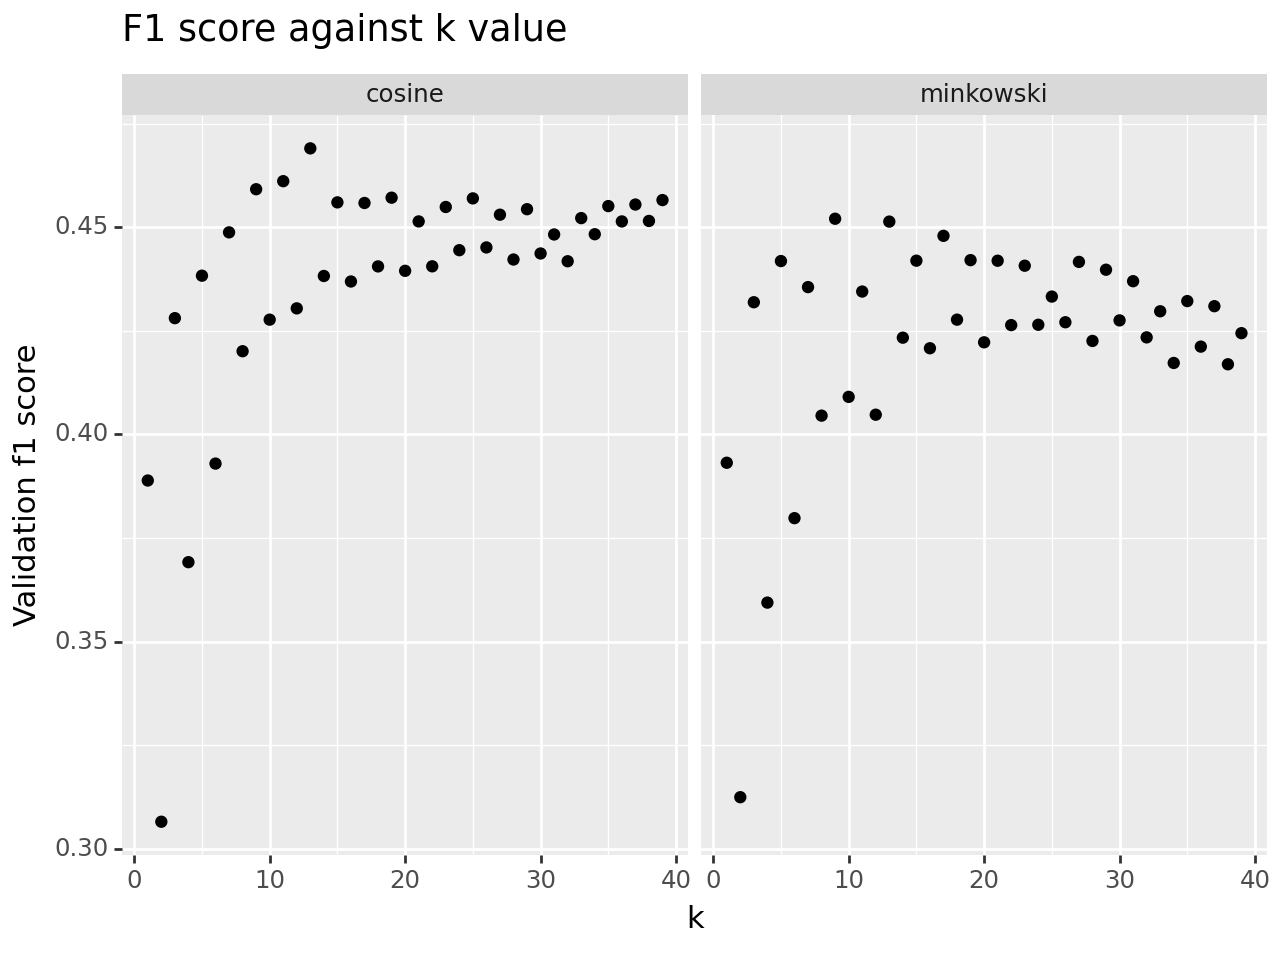

<Figure Size: (640 x 480)>

In [25]:
scores = []
for combo in hyperparameter_tuning_results:
    scores.append( (combo[0], combo[1], hyperparameter_tuning_results[combo]["score"]) )
scores_df = pd.DataFrame(scores, columns=["k", "metric", "score"])

(
    ggplot(scores_df, aes(x="k", y="score")) +
    geom_point() +
    facet_wrap("metric") +
    ggtitle("F1 score against k value") +
    ylab("Validation f1 score")
)

In [26]:
best_combo = None
best_score = 0
for combo in hyperparameter_tuning_results:
    score = hyperparameter_tuning_results[combo]['score']
    if score >= best_score:
        best_score = score
        best_combo = combo
best_score
best_combo

0.46900584795321637

(13, 'cosine')

In [27]:
# final model
final_knn_model = KNeighborsClassifier(n_neighbors = best_combo[0], metric = best_combo[1])
_ = final_knn_model.fit(X_train_validation, y_train_validation)
y_hat_test = final_knn_model.predict(X_test)
f1_score(y_test, y_hat_test)

0.43385214007782097

Now we try hyperparameter tuning, but with sklearn CV grid search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [28]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

# define the parameter grid as a dictionary of lists, where the keys are the names of the parameters
param_grid = {'n_neighbors': k_grid, 'metric': distances_grid}

sklearn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=-1, cv=fold_index, scoring='f1')

# # now perform the grid search on train+validation. Note that the fold_index above encodes which observations are train and which are validation
start_time = datetime.datetime.now()
sklearn_grid_search.fit(X=X_train_validation, y=y_train_validation)
end_time = datetime.datetime.now()
print(f'hypertuning with sklearn grid search complete in {round((end_time - start_time).seconds/60, 2)} minutes')

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'cosine'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='f1')

hypertuning with sklearn grid search complete in 2.3 minutes


In [29]:
sklearn_grid_search.best_estimator_

KNeighborsClassifier(metric='cosine', n_neighbors=13)

In [30]:
sklearn_grid_search.best_score_

0.46900584795321637

## Modeling with random forests

And now with random forests :)

In [31]:
# hyperparameter tuning with crossvalidation of a random forest model
param_grid = {
    "n_estimators": [x for x in range(10, 200, 10)],
    "max_depth": [x for x in range(5, 21, 5)]
}
sklearn_grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1, scoring='f1')
_ = sklearn_grid_search_rf.fit(X_train_validation, y_train_validation)

In [32]:
sklearn_grid_search_rf.best_estimator_
sklearn_grid_search_rf.best_score_

RandomForestClassifier(max_depth=20, n_estimators=120)

0.47977171575895977

We see that the f1 score of random forest is much higher than the other models on the validation dataset. This is promising: random forest might be the best model on the test data. Let's check.

In [33]:
# final f1 test score
# random forest provides the best model on this dataset
y_hat_test = sklearn_grid_search_rf.predict(X_test)
f1_score(y_test, y_hat_test)

0.4698504582730343

Indeed, with 0.47 f1 score random forest in indeed the best model of the bunch.

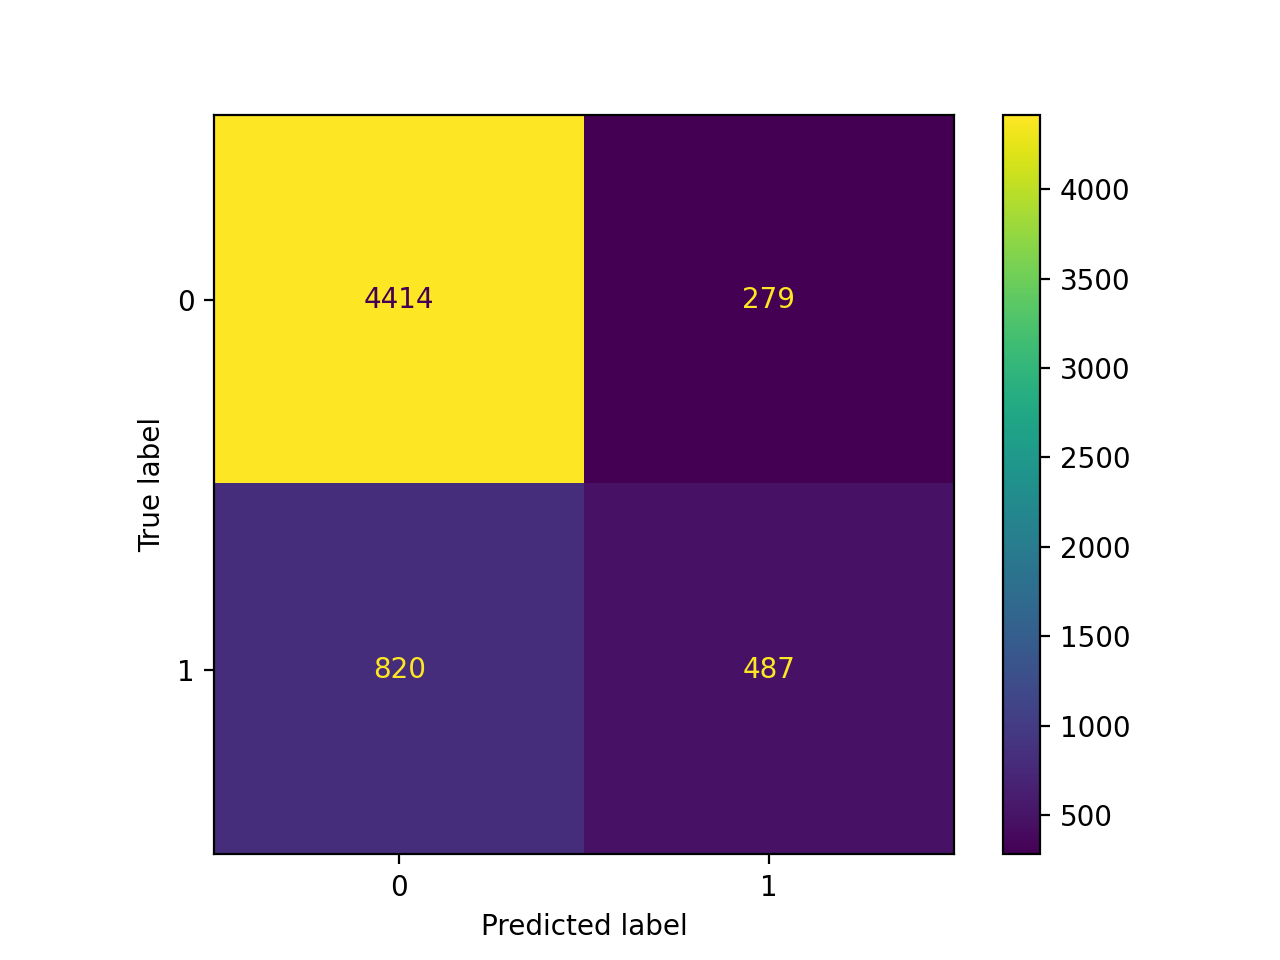

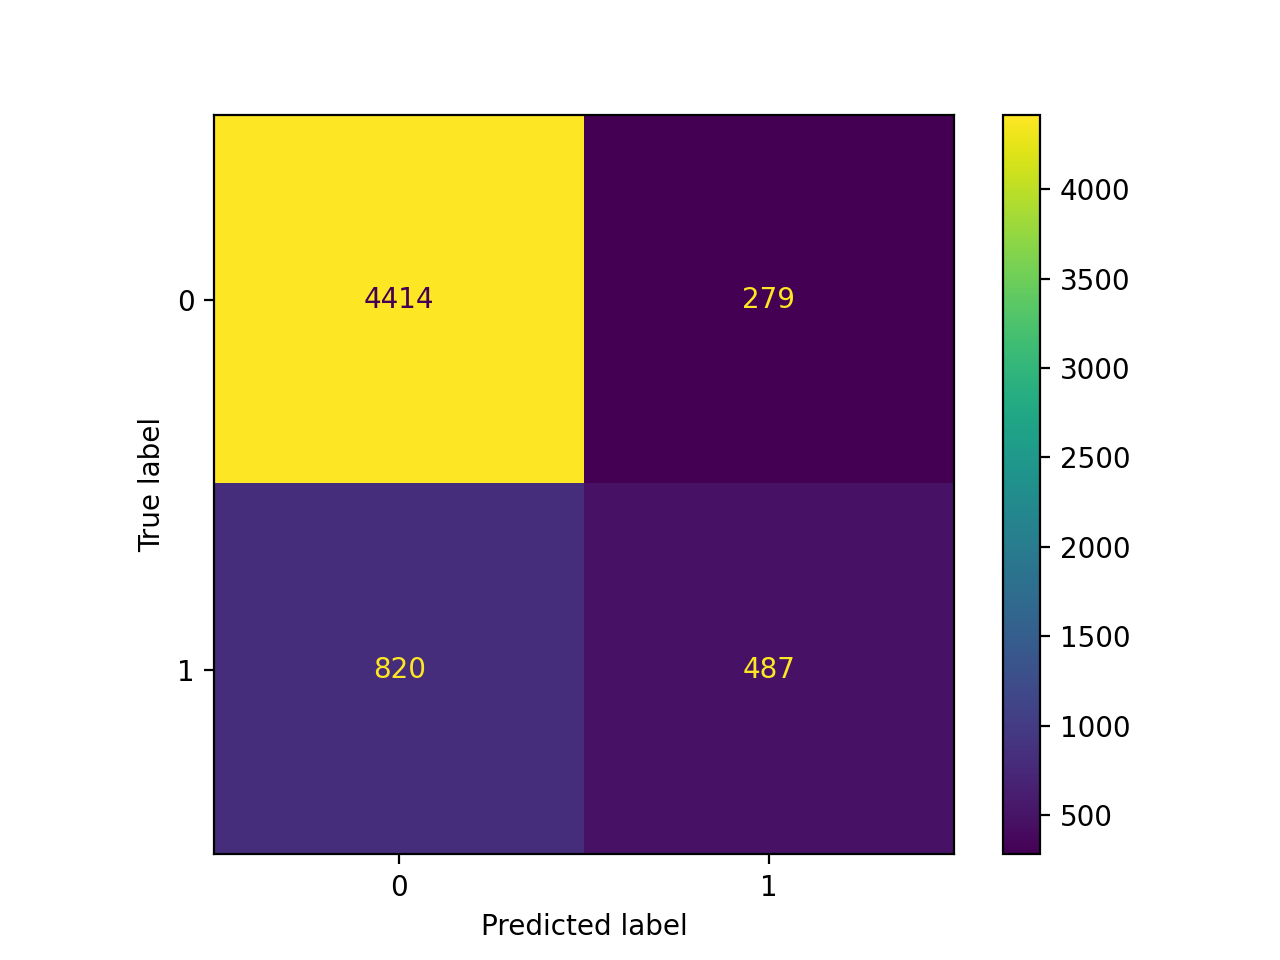

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(sklearn_grid_search_rf.best_estimator_, X_test, y_test)
disp.plot()
plt.show()

In [35]:
precision_score(y_test, y_hat_test)
recall_score(y_test, y_hat_test)

0.6357702349869452

0.3726090283091048

We can see that the higher f1 score is mostly driven by high precision, but recall is quite a bit lower.

## Modeling with neural networks

We can try another model on the above problem. Let's try a simple feed-forward neural network.
For this we need scipy and keras packages installed in the environment. Moreover, we need to have a keras backend (Theano or Tensorflow) installed. We will use Tensorflow here.
We can install all these packages by typing the following commands in a terminal with conda activated:
- conda install scipy
- pip install tensorflow keras

Or, you can install the relevant packages in your environment from the conda UI.

In [ ]:
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

In [ ]:
import keras
print('keras: %s' % keras.__version__)

In [ ]:
# import what we need from keras
from keras.models import Sequential
from keras.layers import Dense

Now, keras is just an interface to Tensorflow (or Theano) that makes it easier to define a neural network architecture. It contains shortcuts to define a variety of architectures and their layers. Here, we will use the simple Sequential model, that is used to define feedforward neural networks; and we will use the Dense layer, which is used to specify dense (i.e. fully conencted) layers of neurons in the sequential network.

Note that for each dense layer, we will have to specify how many neurons that layer should contain. For the input layer, i.e., the first layer in the feedforward network, the number of neurons must be equal to the number of features that are to be used for training; that is, each input neuron will correspond to an input feature.

Intermediate layers of the network can have variable numbers of neurons, each with its associated weight. Each neuron encodes a linear combination of the values of the neurons that feed into it, weighted by the corresponding coefficients.

In [ ]:
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

In [ ]:
# define the neural network model class instance
simple_nn = Sequential()
# add the first input layer with 29 nodes and the first hidden layer, with  relu activation function
# note that the first command does two things: create a first input layer with 29 nodes, and then a hidden layer
# we set the number of neurons to be equal to the (# of nodes in the input layer + # neurons in the output layer)/2,
# i.e. the mean of the number of neurons in the input layer and the output layer. This is usually a good heuristic to get started.
simple_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
# add the output layer with sigmoid function (the sigmoid function is exactly the same as that used in the formulation of logisitc regression
simple_nn.add(Dense(1, activation='sigmoid'))

In [ ]:
print(simple_nn.summary())

After the model has been defined, it needs to be compiled to tensorflow code to be able to be trained.

Here we also need to choose the cost function to optimize for in the backpropagation algorithm.
Since we are doing classification, we will use cross entropy. 

As the algorithm for to do backpropagation, we will use adam. See https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for a gentle tutorial on stochastic gradient descent using adam.

In [ ]:
simple_nn.compile(loss='binary_crossentropy', optimizer='adam')

Note that we use the binary_crossentropy loss function in the above model. Remember that the loss function is the function that encodes the error of the prediction by the NN on a given observation w.r.t. the observation's true value. The gradient descent algorithm tries to adjust the weights of the neural network so that this error is minimized. 

The cross entropy function for a binary classification problem is defined as:

-(y log(p) + (1-y) log(1-p))

where y is the actual label (0 or 1), and p is the probability that the model predicts for the 1 (positive) class.

The underlying intuition is that the cross entropy loss increases the more the predicted probability for the correct class (in the range 0-1) differs from the correct class (either 0 or 1).

<div>
<img src="img/logloss.png" width="500">
</div>

See https://machinelearningmastery.com/cross-entropy-for-machine-learning/ for a more extensive discussion of the cross entropy and log loss functions.

Now that we have the compiled model, we can fit it on the training set. The interface here is similar to that of sklearn: we can call the .fit method on the compiled simple_nn model, and fit our model on the training set.

Note that training for a neural network model in keras goes a bit differently that for other machine learning algorithms. Here, training occurs over different **epochs**. Each **epoch** is split into **batches**. Epochs and batches are defined as:

- epoch: one forward-and-backprop pass through every row in the training set
- batch: the number of samples that are considered for each backpropagation update of the weights of the network

Each epoch consists of multiple weights update actions, one for each batch that the training dataset is divided into. There are two extreme cases: all the observations in training are in one single batch, or each individual observations is in its own separate batch.

In the first case, the model will:
1. calculate the error from all the observations in the unique batch 
2. use it do update the weights of the network
3. complete the epoch

In the second case, the model will:
1. calculate the error for the first batch (first observation)
2. update the weights of the network
3. calculate the error for the second batch (second observation)
4. update the error
5. repeat the steps above for all the observations in the training set
6. complete the epoch

Of course, these are two extreme cases. But one can set different values for the batch size, e.g., 10. Then the observations are grouped in groups of size 10 (the batches), and the algorithm loops though each batch, predicting, backpropagating, and updating the weights after each batch. When all batches are done, one epoch has passed.

Terminology:

- Batch Size = Size of Training Set -> Batch Gradient Descent
- Batch Size = 1 -> Stochastic Gradient Descent
- 1 < Batch Size < Size of Training Set -> Mini-Batch Gradient Descent


<div>
<img src="img/batches_epochs.jpeg" width="500">
</div>

In [ ]:
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

In [ ]:
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 20)

Note that when we fit the model, keras prints the value of the loss function at the end of each epoch. Here, the value of the loss function is calculated on the training set itself.
You can see that the loss is monotonically decreasing over the epochs, until it reaches a plateau:

In [ ]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 151))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

We can see that the training loss is decreasing almost linearly after each epoch. This suggests that we could in principle increase the number of epochs to achieve better predictions.

However, note that this is the loss computed at the end of each epoch on the **training set**. Thus, just looking at this loss can lead to **overfitting**. Increasing the number of epochs radically will lower the loss on the training set, but the loss on a set that the model has not been trained on could be much worse if the model is just reducing the loss on the training set by learning noise.

We can provide our validation dataset to keras in order to evaluate, at the end of each epoch, the loss on the validation dataset. This will allow us to detect if the model starts to overfit, for instance.

In [ ]:
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 20, validation_data=(X_validation, y_validation))

In [ ]:
# plot the training loss over epochs
def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch = np.arange(1, 151))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks = np.arange(0, 150, 10)) +
        ylab("Loss")
    )
    return p

plot_loss(simple_nn)

In [ ]:
# save the above simple nn fitted model to look at it later. We need to use the keras save command
# this command will save all the components of the model, in particular the architecture and the weights
# note: it will NOT save the training history. This needs to be saved separately.
simple_nn.save('../dataset/simple_nn_model')

print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

In [ ]:
# we can load the above save model like this:
simple_nn = keras.models.load_model("../dataset/simple_nn_model")
simple_nn

# reload the fitting history like this
with open("../dataset/simplen_nn_history.json", "r") as handle:
    simple_nn_history = json.load(handle)

After we have determined at least the number of epochs that give us the best results on the validation dataset, we can train the model on the full train + validation set, and predict on the test set to get a final value for the model performance.

In [ ]:
final_nn = Sequential()
final_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
final_nn.add(Dense(1, activation='sigmoid'))
final_nn.compile(loss='binary_crossentropy', optimizer='adam')
final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size = 20, verbose=0)
y_hat_test_nn = final_nn.predict(X_test)
y_hat_test_nn = np.where(y_hat_test_nn >= 0.5, 1, 0)
print("The f1 score of the nn model is {}".format(f1_score(y_test, y_hat_test_nn)))

We have improved on the score fo the SVC! We now have 0.475 as f1 score rather than the 0.45 produced by the SVC.
Note however that there is a lot of randomness built in neural network models. If we reran the fitting process of the above model, most likely we would obtain slightly different results.
It is best practice to fit a selected model multiple times and generate multiple scores on the test set. These can highlight if there are stability issues with the model, in case there is a large variance in the scores so produced. Moreover, they can be averaged to obtain a final preformance metric for the model on the test set.

If we try with a network with a lot of hidden neurons and hidden layers, we see that we will start overfitting very rapidly: the loss on the validation set will start to skyrocket almost immediately, while the loss on the training set will keep decreasing monotonically.

In general, the number of neurons and hidden layers in the network influences a lot the performance of the network. If you have many hidden layers with a lot of neurons, and the dimensionality of your data (# of features) is much smaller than the number of hidden neurons in the network, you are very likely to overfit the data.

On the other hand, if you have few neurons compared to the dimensionality of your data; for instance if you have hundreds of features (such as in image recognition problems, where each pixel is a feature), but just one hidden layer with 10 neurons, or even no hidden layer (in which case the neural network reduces to a linear regression), then you are very likely to underfit the data.

In [ ]:
oversized_nn = Sequential()
oversized_nn.add(Dense(60, input_dim=X_train.shape[1], activation='relu'))
oversized_nn.add(Dense(40, activation='relu'))
oversized_nn.add(Dense(15, activation='relu'))
oversized_nn.add(Dense(1, activation='sigmoid'))
oversized_nn.compile(loss="binary_crossentropy", optimizer="adam")
oversized_nn.fit(X_train, y_train, epochs=150, batch_size = 20, validation_data=(X_validation, y_validation))

In [ ]:
plot_loss(oversized_nn)

We can see that the neural network starts overfitting almost immediately.
In general, it is a good heuristic to start with a simple network with a # of hidden neurons equal to around half of the dimensionality of the feature space. However, the best number of neurons can best be determined with hypertuning.

## Hypertuning of neural network: batches, epochs, layers

There are many hyperparameters that can be tuned for neural networks: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Here we just show how we can tune batch size, number of epochs, and number of neurons in the hidden layers, with a simple grid search.

Note that in the above link, they use keras.wrappers.scikit_learn to turn a keras model into a sklearn model. However, this method is superseded by the scikeras package, which is the one we use below.
You can install this package by doing:

- pip instal scikeras

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [ ]:
# function that creates the model
# note that we pass the number of neurons as a parameter to the network
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))
    nn_model.add(Dense(1, activation='sigmoid'))
    nn_model.compile(loss='binary_crossentropy', optimizer='adam')
    return nn_model

seed = 1234
np.random.seed(seed)

# turn the keras model into a sklearn compatible model
# note that the neurons parameter needs to be specified in the interface of KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [ ]:
# define the grid search parameters
batch_size = [10, 20]
epochs = [100, 150]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [ ]:
params_grid

In [ ]:
# perform grid search with sklearn if needed, otherwise load the grid search already performed
if os.path.exists("../dataset/nn_grid_search.pickle") and USE_STORED_NN_HYPERTUNED_MODELS is True:
    with open('../dataset/nn_grid_search.pickle', 'rb') as handle:
        grid_search_nn = pickle.load(handle)
else:
    start_time = datetime.datetime.now()
    grid_search_nn = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, cv=fold_index)
    grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')
    # store the results of the grid search to disk
with open('../dataset/nn_grid_search.pickle', 'wb') as handle:
    pickle.dump(grid_search_nn, handle)

In [ ]:
grid_search_nn

In [ ]:
print("The best parameter combination is: {} with score: {}".format(grid_search_nn.best_params_, grid_search_nn.best_score_))

We now train a model with the best parameters found on train and validation, together:

In [ ]:
best_model = create_model(20)
best_model.fit(X_train_validation, y_train_validation, epochs=100, batch_size=10, verbose=0)

We can then evaluate the model so trained on the test set:

In [ ]:
y_hat_test = best_model.predict(X_test)
y_hat_test = np.where(y_hat_test >= 0.5, 1, 0)
f1_score(y_test, y_hat_test)

This is worse than the results obtained above, but note that the hypertuning has identified as the best number of nodes (20) the number of nodes we used above.

The underperformance here is most likely due to the grid search being too small, for instance we saw above that the model with 20 neurons does better when the epochs are on the small side (20-60).
Here we only have 100 and 150 epochs in the grid search.

We would then be able to improve the results if we had a finer grid using the insights from the quick test above to zone in on the parameters that are more likely to yield good performance (e.g., epochs < 100).